# **Классификация текстов**
### **1.** Классификация категорий новостного корпуса с помощью моделей классического машинного обучения(добиться как можно лучшего качества).
### **2.** Анализ полученных результатов.

In [ ]:
import os
import numpy as np
import lxml
from lxml import objectify, etree, html
from xml.etree import ElementTree as xml
import urllib3
from io import StringIO, BytesIO
import pandas as pd
import re
import codecs
from pymystem3 import Mystem
import copy
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords
import sklearn
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import itertools
import json
import random
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from json2xml import json2xml, readfromurl, readfromstring, readfromjson
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Чтение данных

In [ ]:
news = []
with open('rambler_news.json') as file:
    for line in file:
        news.append(json.loads(line))

Перемешаем статьи для нормального обучения, т.к. сначала идут тексты одной категории, потом другой.

In [ ]:
random.shuffle(news)
news

[{'link': 'https://sport.rambler.ru/boxing/43606526-federatsiya-boksa-rossii-vyskazalas-o-zaderzhanii-kushitashvili/?utm_source=head&utm_campaign=self_promo&utm_medium=news&utm_content=news&h_sp=1\n',
  'category': 'sport',
  'title': 'Федерация бокса России высказалась о задержании Кушиташвили',
  'text': 'Федерация бокса России 3 февраля проведет разбирательство инцидента с участием двукратного чемпиона России Георгия Кушиташвили.   Телеграм-канал Baza сообщил, что Кушиташвили и его друг, боксер Овик Оганнисян были задержаны, когда забирали наркотики в подъезде дома в Москве. Кушиташвили оказал сопротивление и сломал нос сотруднику Росгвардии. В свертке, который нашли у него, оказалось чуть меньше грамма неизвестного вещества. По предварительным данным, это был кокаин.   Кушиташвили в составе сборной России участвовал в прошлогоднем чемпионате мира, на котором дошел до 1/4 финала. Он является двукратным чемпионом России (2015, 2018), бронзовым призером чемпионата страны (2016) в весо

## Preprocessing

Текст каждый статьи приводим к нижнему регистру, удаляем знаки препинаия, цифры, стоп-слова и нормализуем.

А категории для классификаторов переводим в числовой формат.

In [ ]:
def preprocess_article(text, mystem=Mystem(entire_input=False)):
    text = text.lower()
    ru_stopwords = stopwords.words('russian')
    dgts = [str(i) for i in range(10)]
    for s in string.punctuation:
        text = text.replace(s, '')
    text = re.sub( '\s+', ' ', text).strip()
    
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in ru_stopwords\
              and token not in dgts\
              and token != " "]
    text = " ".join(tokens)
    return text

def preprocess_doc(catalog):
    preproc_catalog = copy.deepcopy(catalog)
    for i in range(len(preproc_catalog)):
        preproc_catalog[i] = preprocess_article(catalog[i])
    return preproc_catalog

In [ ]:
categories = ['world', 'kino', 'tech', 'doctor', 'sport', 'politics', 'finance']

data, labels_w = list(), list()
count = 0
for i in range(len(news)):
    category = news[i]['category']
    data.append(news[i]['text'])
    labels_w.append(category)

labels = [categories.index(lb) for lb in labels_w]        
print(len(data), len(labels_w), len(labels))

197 197 197


In [ ]:
labels_w

['sport',
 'finance',
 'world',
 'finance',
 'world',
 'kino',
 'politics',
 'kino',
 'doctor',
 'tech',
 'tech',
 'finance',
 'finance',
 'sport',
 'sport',
 'politics',
 'kino',
 'sport',
 'doctor',
 'sport',
 'politics',
 'finance',
 'world',
 'world',
 'doctor',
 'kino',
 'kino',
 'finance',
 'kino',
 'politics',
 'world',
 'sport',
 'finance',
 'finance',
 'kino',
 'world',
 'kino',
 'doctor',
 'politics',
 'sport',
 'finance',
 'kino',
 'kino',
 'politics',
 'doctor',
 'world',
 'kino',
 'doctor',
 'politics',
 'kino',
 'world',
 'tech',
 'tech',
 'doctor',
 'world',
 'politics',
 'kino',
 'world',
 'tech',
 'tech',
 'politics',
 'doctor',
 'politics',
 'world',
 'doctor',
 'finance',
 'doctor',
 'world',
 'sport',
 'tech',
 'politics',
 'finance',
 'world',
 'tech',
 'tech',
 'doctor',
 'sport',
 'kino',
 'politics',
 'world',
 'finance',
 'tech',
 'sport',
 'world',
 'doctor',
 'doctor',
 'kino',
 'world',
 'kino',
 'sport',
 'tech',
 'sport',
 'finance',
 'politics',
 'world',

In [ ]:
data

['Федерация бокса России 3 февраля проведет разбирательство инцидента с участием двукратного чемпиона России Георгия Кушиташвили.   Телеграм-канал Baza сообщил, что Кушиташвили и его друг, боксер Овик Оганнисян были задержаны, когда забирали наркотики в подъезде дома в Москве. Кушиташвили оказал сопротивление и сломал нос сотруднику Росгвардии. В свертке, который нашли у него, оказалось чуть меньше грамма неизвестного вещества. По предварительным данным, это был кокаин.   Кушиташвили в составе сборной России участвовал в прошлогоднем чемпионате мира, на котором дошел до 1/4 финала. Он является двукратным чемпионом России (2015, 2018), бронзовым призером чемпионата страны (2016) в весовой категории до 81 кг.   «Мне уже сообщили об этом. В понедельник досконально узнаем, что произошло. Если они действительно что-то нарушили, то я считаю, что они должны понести жесткое наказание», — сказал генеральный секретарь Федерации бокса России Умар Кремлев, слова которого приводит ТАСС.   ',
 'С 1 

In [ ]:
labels

[4,
 6,
 0,
 6,
 0,
 1,
 5,
 1,
 3,
 2,
 2,
 6,
 6,
 4,
 4,
 5,
 1,
 4,
 3,
 4,
 5,
 6,
 0,
 0,
 3,
 1,
 1,
 6,
 1,
 5,
 0,
 4,
 6,
 6,
 1,
 0,
 1,
 3,
 5,
 4,
 6,
 1,
 1,
 5,
 3,
 0,
 1,
 3,
 5,
 1,
 0,
 2,
 2,
 3,
 0,
 5,
 1,
 0,
 2,
 2,
 5,
 3,
 5,
 0,
 3,
 6,
 3,
 0,
 4,
 2,
 5,
 6,
 0,
 2,
 2,
 3,
 4,
 1,
 5,
 0,
 6,
 2,
 4,
 0,
 3,
 3,
 1,
 0,
 1,
 4,
 2,
 4,
 6,
 5,
 0,
 2,
 5,
 4,
 6,
 4,
 5,
 0,
 5,
 1,
 5,
 2,
 4,
 3,
 0,
 6,
 4,
 3,
 3,
 2,
 3,
 3,
 0,
 4,
 2,
 0,
 4,
 3,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 6,
 4,
 5,
 1,
 4,
 4,
 1,
 5,
 3,
 2,
 1,
 2,
 6,
 2,
 2,
 1,
 4,
 4,
 1,
 6,
 2,
 3,
 5,
 6,
 3,
 4,
 4,
 0,
 0,
 3,
 6,
 4,
 1,
 2,
 5,
 6,
 0,
 2,
 6,
 4,
 3,
 2,
 4,
 0,
 2,
 5,
 3,
 1,
 4,
 1,
 1,
 0,
 2,
 1,
 2,
 3,
 2,
 3,
 1,
 5,
 1,
 2,
 2,
 4,
 6,
 4,
 6,
 4]

In [ ]:
preproc_data = preprocess_doc(data)
preproc_data

['федерация бокс россия февраль проводить разбирательство инцидент участие двукратный чемпион россия георгий кушиташвили телеграмканал baza сообщать кушиташвили друг боксер овик оганнисян задерживать забирать наркотик подъезд дом москва кушиташвили оказывать сопротивление сломать нос сотрудник росгвардия сверток который находить оказываться мало грамм неизвестный вещество предварительный данные это кокаин кушиташвили состав сборная россия участвовать прошлогодний чемпионат мир который доходить финал являться двукратный чемпион россия бронзовый призер чемпионат страна весовой категория кг сообщать это понедельник досконально узнавать происходить действительно чтото нарушать считать должный понести жесткий наказание сказать генеральный секретарь федерация бокс россия умар кремлев слово который приводить тасс',
 'февраль год любой житель дальневосточный федеральный округ дфо мочь получать земля забайкальский край бурятия рамка программа дальневосточный гектар август год участок регион нач

In [ ]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Разделение на train/test

Соотношение 70% к 30%.

In [ ]:
data_train = preproc_data[0:137]
category_train = labels[0:137]

data_test = preproc_data[137::]
category_test = labels[137::]

print(len(data_train), len(category_train), len(data_test), len(category_test))

137 137 60 60


In [ ]:
y_train, y_test = list(), list()

for data, lbl in log_progress(zip(data_train, category_train), 10, len(data_train)):
    y_train.append(lbl)
y_train = np.asarray(y_train)
print(len(data_train), len(y_train))

for data, lbl in log_progress(zip(data_test, category_test), 10, len(data_test)):
    y_test.append(lbl)
y_test = np.asarray(y_test)
print(len(data_test), len(y_test))

137 137


60 60


Признаки для будующих классификаторов получаем с помощью TF-IDF.

In [ ]:
vectorizer = TfidfVectorizer(stop_words=set(stopwords.words('russian')))
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

print(X_train.shape, X_test.shape)

(137, 5680) (60, 5680)


Смотрю сколько текстов каждой категории взято в набор train. И сверяюсь с его размером.

In [ ]:
for c in np.unique(np.asarray(y_train)):
    print('Class \'{}\' samples N: {}'.format(c, np.asarray(y_train)[np.asarray(y_train) == c].shape[0]))

Class '0' samples N: 23
Class '1' samples N: 21
Class '2' samples N: 18
Class '3' samples N: 19
Class '4' samples N: 21
Class '5' samples N: 19
Class '6' samples N: 16


## Build Models

* **Logistic Regression**
* **SVM**
* **Random Forest**
* **Gradient Boosting Trees**
* **Naive Bayes**
* **AdaBoost**
* **kNN** 
* **MLP** (Multi-layer Perceptron classifier)

### Define classifiers:

In [ ]:
predictor_lr = LogisticRegression().fit(X_train, y_train)

In [ ]:
predictor_svm = LinearSVC().fit(X_train, y_train)

In [ ]:
predictor_rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [ ]:
predictor_gbt = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)

In [ ]:
predictor_nb = MultinomialNB(alpha=1).fit(X_train, y_train)

In [ ]:
predictor_ab = AdaBoostClassifier(n_estimators=200).fit(X_train, y_train)

In [ ]:
predictor_knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1).fit(X_train, y_train)

In [ ]:
predictor_mlp = MLPClassifier(alpha=1, max_iter=1000).fit(X_train, y_train)

### Evaluate Classifiers:

In [ ]:
y_pred_lr = predictor_lr.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr), 2)))

LR accuracy: 0.73%


In [ ]:
y_pred_svm = predictor_svm.predict(X_test)
print('SVM accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm), 2)))

SVM accuracy: 0.82%


In [ ]:
y_pred_rf = predictor_rf.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.68%


Попытаюсь улучшить точность, подобрав параметры.

In [ ]:
distr = {
    'n_estimators': [5, 10, 40, 80, 100, 200, 500, 1000],
    'max_depth': [5, 10, 15, 20, 40],
    'max_features': ["auto", "sqrt", "log2", None]
}
rf_gs = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), n_iter=100, 
                           param_distributions=distr, n_jobs=-1)

In [ ]:
rf_gs = rf_gs.fit(X_train, y_train)

In [ ]:
rf_gs.best_params_

{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 40}

In [ ]:
rf_gs.best_score_

0.7661375661375661

Построю новый классификатор RandomForest с лучшими параметрами.

In [ ]:
predictor_rf2 = RandomForestClassifier(n_estimators=100, max_depth=40).fit(X_train, y_train)
y_pred_rf2 = predictor_rf2.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf2), 2)))

RF accuracy: 0.8%


In [ ]:
y_pred_gbt = predictor_gbt.predict(X_test)
print('GBT accuracy: {}%'.format(round(np.mean(y_test == y_pred_gbt), 2)))

GBT accuracy: 0.75%


In [ ]:
y_pred_nb = predictor_nb.predict(X_test)
print('NB accuracy: {}%'.format(round(np.mean(y_test == y_pred_nb), 2)))

NB accuracy: 0.65%


In [ ]:
y_pred_ab = predictor_ab.predict(X_test)
print('AB accuracy: {}%'.format(round(np.mean(y_test == y_pred_ab), 2)))

AB accuracy: 0.35%


Результат AdaBoost точно надо улучшить.

In [ ]:
distr_ab = {
    'base_estimator': [DecisionTreeClassifier(max_depth=10), DecisionTreeClassifier(max_depth=40)],
    'n_estimators': [5, 10, 40, 80, 100, 200, 500, 1000],
}
ab_gs = RandomizedSearchCV(AdaBoostClassifier(), n_iter=100, 
                           param_distributions=distr_ab, n_jobs=-1)

In [ ]:
ab_gs = ab_gs.fit(X_train, y_train)

In [ ]:
ab_gs.best_params_

{'n_estimators': 500,
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best')}

In [ ]:
ab_gs.best_score_

0.6780423280423281

In [ ]:
predictor_ab2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=500).fit(X_train, y_train)
y_pred_ab2 = predictor_ab2.predict(X_test)
print('AB accuracy: {}%'.format(round(np.mean(y_test == y_pred_ab2), 2)))

AB accuracy: 0.73%


Теперь точность AdaBoost - 73% при условии, что base_estimator=DecisionTreeClassifier(max_depth=10) и n_estimators=500.

In [ ]:
y_pred_knn = predictor_knn.predict(X_test)
print('kNN accuracy: {}%'.format(round(np.mean(y_test == y_pred_knn), 2)))

kNN accuracy: 0.72%


Попробую улучшить результат, поискав оптимальное количество ближайших соседей.

In [ ]:
knn_res = {'n': [], 'error': []}
for n in range(2, 15):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1).fit(X_train, y_train)
    knn_res['n'].append(n)
    knn_res['error'].append(1 - np.mean(y_test == knn.predict(X_test)))

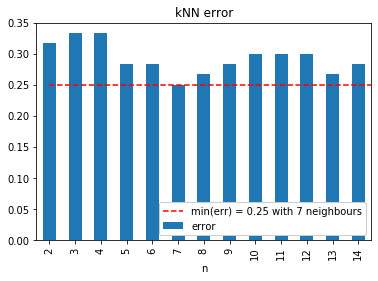

In [ ]:
min_error, min_n = min(zip(knn_res['n'], knn_res['error']), key=lambda x: x[1])
pd.DataFrame.from_dict(knn_res).plot.bar(x='n')
plt.plot([0, 30], [min(knn_res['error'])]*2, '--r', 
         label='min(err) = {:.2f} with {} neighbours'.format(min_n, min_error))
plt.legend(loc='lower right', framealpha=1)
plt.title('kNN error')
plt.show()

In [ ]:
predictor_knn2 = KNeighborsClassifier(n_neighbors=7, n_jobs=-1).fit(X_train, y_train)
y_pred_knn2 = predictor_knn2.predict(X_test)
print('kNN accuracy: {}%'.format(round(np.mean(y_test == y_pred_knn2), 2)))

kNN accuracy: 0.75%


Теперь kNN дает 75% точности при 7 соседях.

In [ ]:
y_pred_mlp = predictor_mlp.predict(X_test)
print('MLP accuracy: {}%'.format(round(np.mean(y_test == y_pred_mlp), 2)))

MLP accuracy: 0.82%


На данном этапе лучшими моделями являются - **SVM** и **MLP**, c точностью предсказания в **82%**.

## Confusion Matrices

In [ ]:
def Conf_Matr(classifier, name_pr):
    title = name_pr + ' Confusion Matrix'
    fig, ax = plt.subplots(figsize=(15,15))
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=categories,
                                     cmap=plt.cm.BuPu,
                                     normalize='true',
                                    xticks_rotation='vertical',
                                    ax=ax)
    disp.ax_.set_title(title)

Теперь для каждого классификатора построим нормализированную confusion matrix, чтобы посмотреть соотношение правильно и не правильно предсказанных категорий (какие категории путаются между собой).

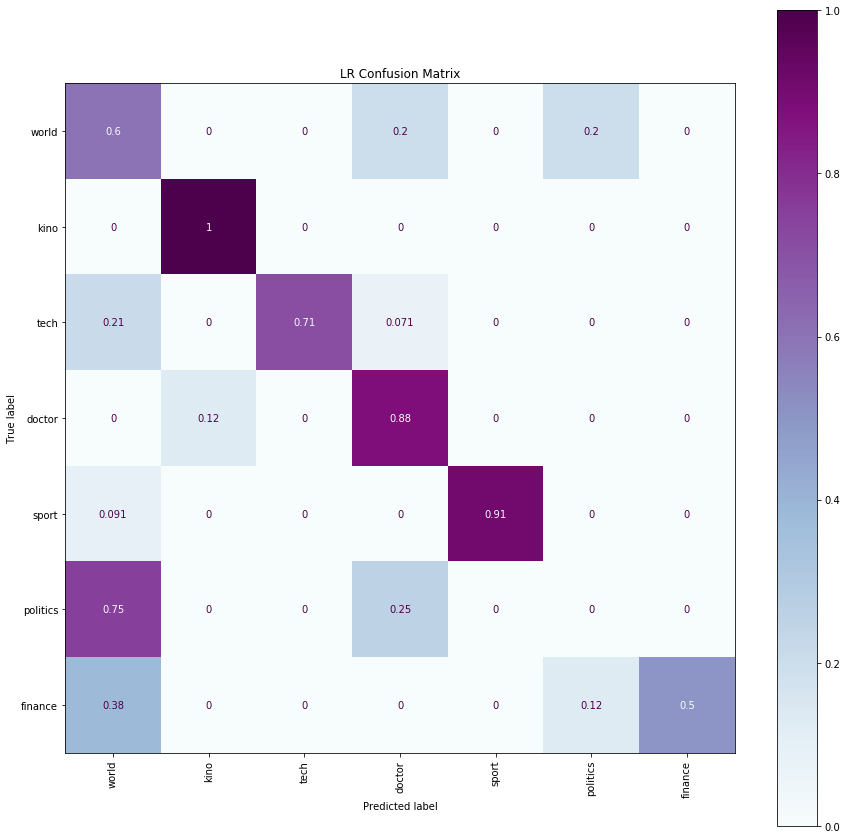

In [ ]:
Conf_Matr(predictor_lr, 'LR')

Логистическая регрессия ошибочно определяет всю категорию политики. Она путает её с категорией в мире и медициной. Если политика и события, происходящие в мире можно спутать, т.к. это связанные понятия очевидно. А вот почему путает с медициной мне не понятно.

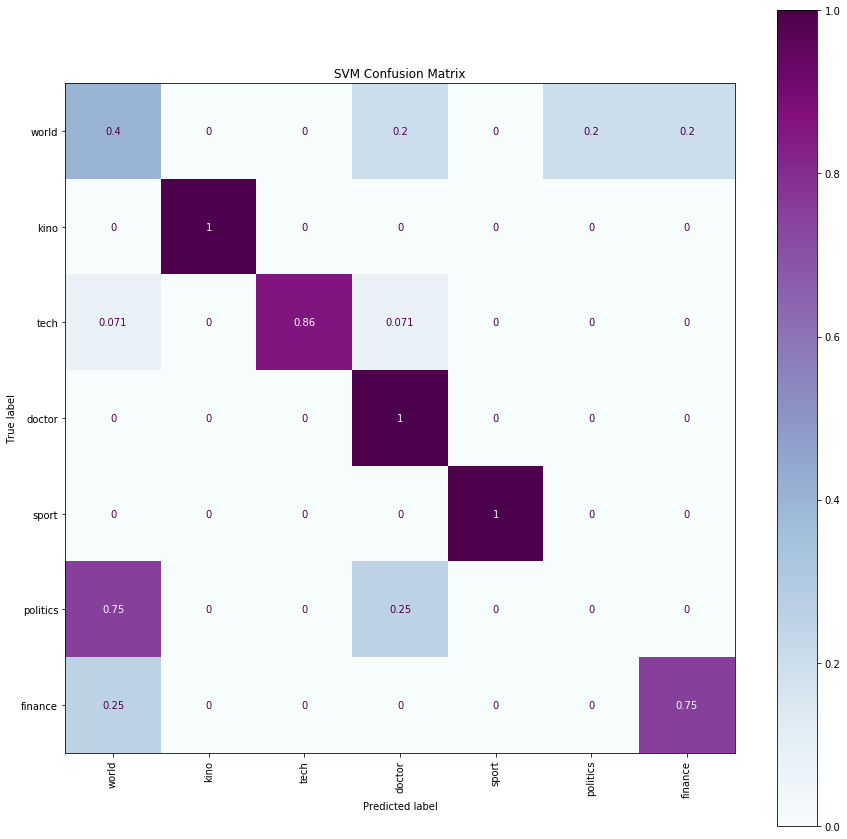

In [ ]:
Conf_Matr(predictor_svm, 'SVM')

SVM по сравнению с LR лучше предсказывает новости из сферы финансов, но хуже определяет принадлежность текста к категории новостей мира.
Он её путает не только с медициной и политикой, но и с финансами.

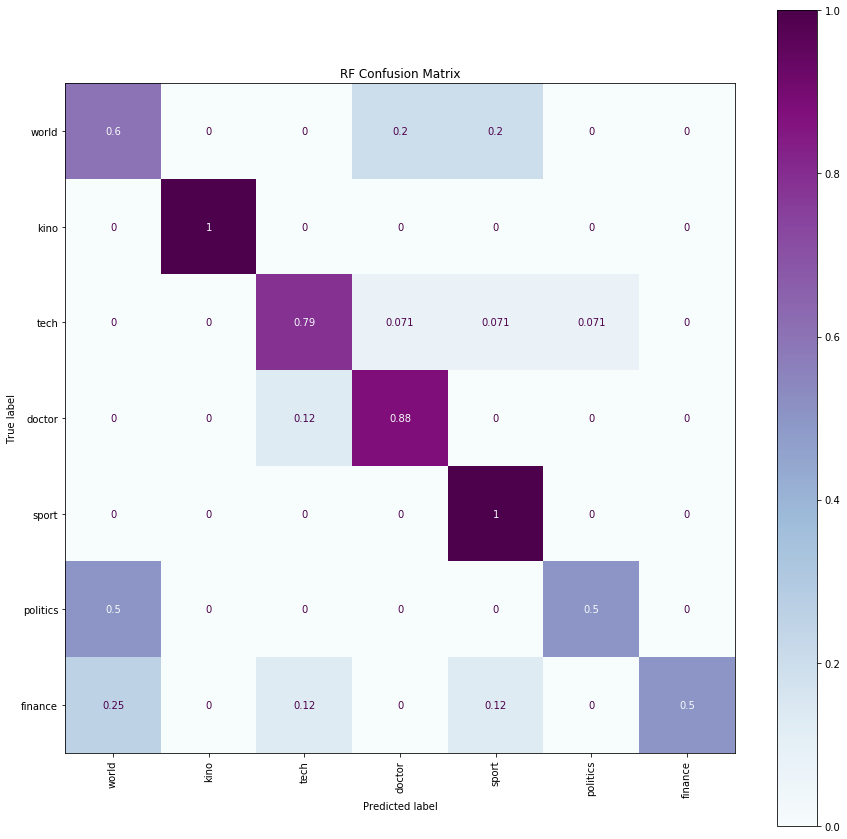

In [ ]:
Conf_Matr(predictor_rf2, 'RF')

Random Forest правильно определяет категорию финансы лишь в половине случаев. Однако, политику он путает теперь только с мировыми новостями, также в 50% случаев.

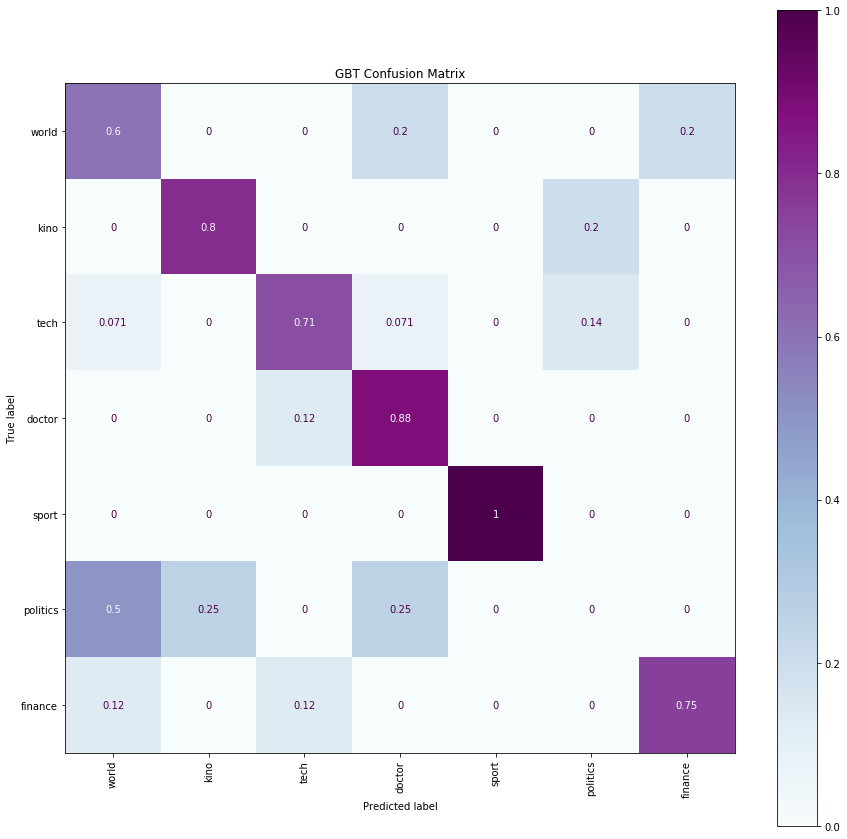

In [ ]:
Conf_Matr(predictor_gbt, 'GBT')

Gradient Boosting стал путать политику в 25% случаев с кино и медициной. А финансы в 12% случаев путает с технологиями и мировыми новостями. 

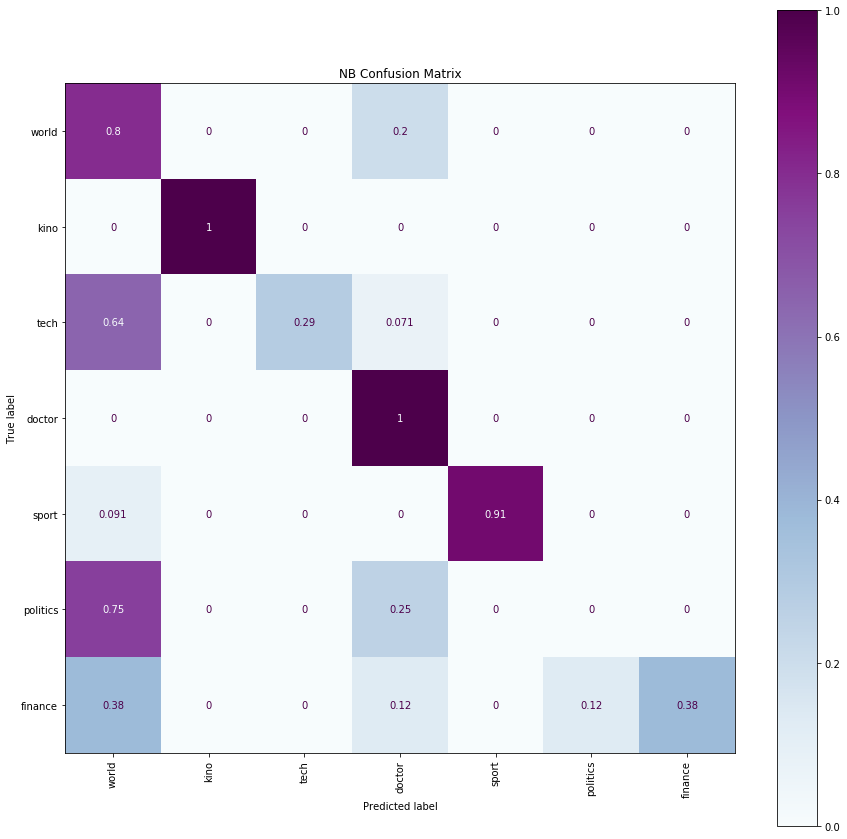

In [ ]:
Conf_Matr(predictor_nb, 'NB')

Наивный Байесовский классификатор абсолютно точно предсказывает тексты из мира кино и медицины, и почти наверняка - спорт и новости, происходящие в мире в общем.

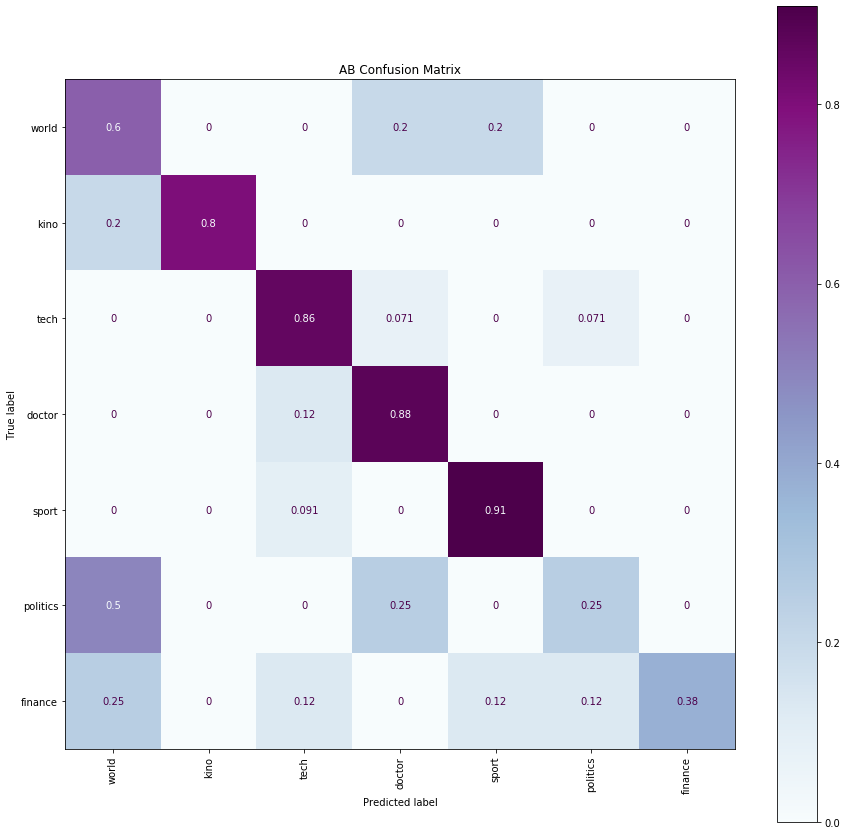

In [ ]:
Conf_Matr(predictor_ab2, 'AB')

Классификатор AdaBoost неправильно определяет финансовый текст в 62% случаев. Также категорию медицины он немного путает с технологиями. Это можно объяснить тем, что в медицинских текстах могут обсуждаться какие-то медицинские аппараты для различных анализов и выявления болезней.

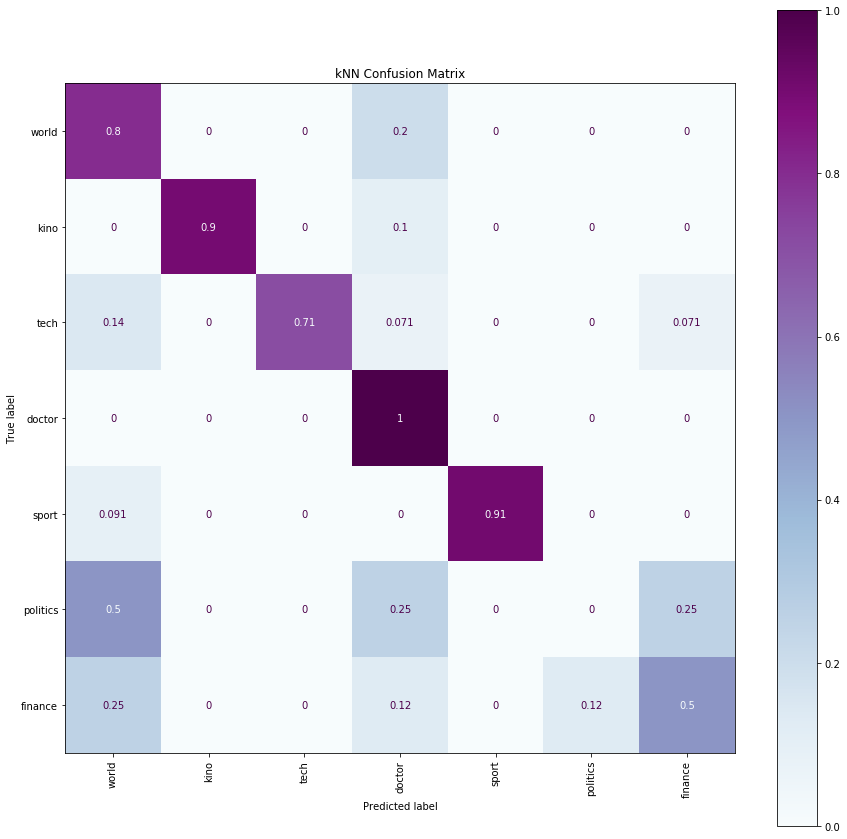

In [ ]:
Conf_Matr(predictor_knn2, 'kNN')

Классификатор k ближайших соседей точно определяет медицину. Довольно точно предсказывает кино, спорт и новости, происходящие во всем мире. Финансы он путает с мировыми новостями, медициной и политикой, но в половине случаев предсказывает принадлежность текста к своей категории верно.

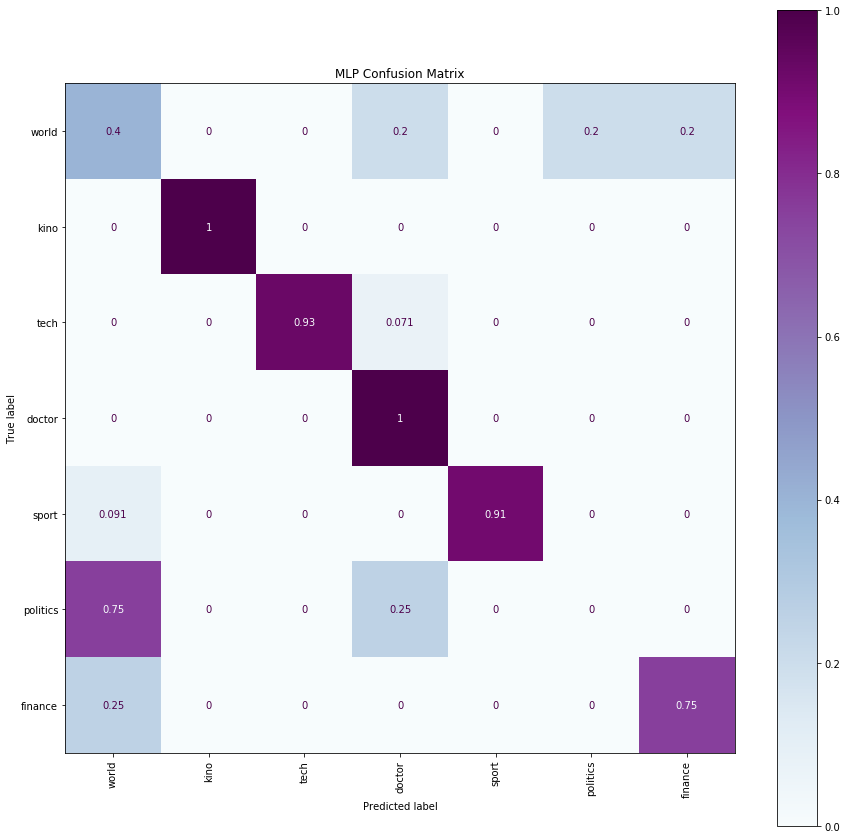

In [ ]:
Conf_Matr(predictor_mlp, 'MLP')

MLP классификатор хорошо определяет 4 категории: кино, технологии, медицину, спорт.

**Важное наблюдение**: каждый классификатор путает политику с мировыми новостями и медициной. А большинство из них, политические тексты к политике вообще не относит (6/8). 

По визуализированным матрицам трудно определить наилучший классификатор, потому что все относительно. Каждый путает разные категории в разных пропорциях.

### Feature Importances:

Теперь попробуем выявить наиболее важные признаки на основе лесов из деревьев.

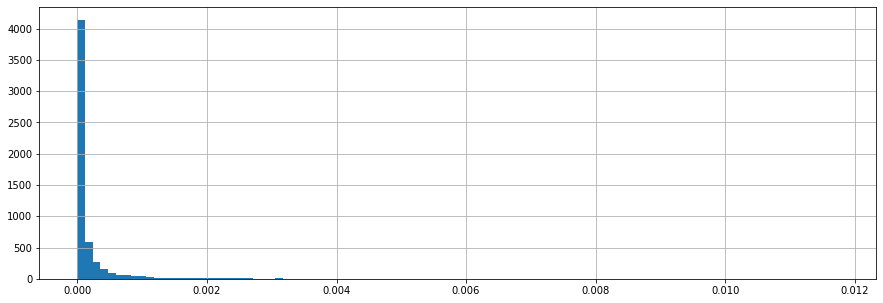

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(predictor_rf2.feature_importances_, bins=100)
plt.grid(True)

(0, 0.002)

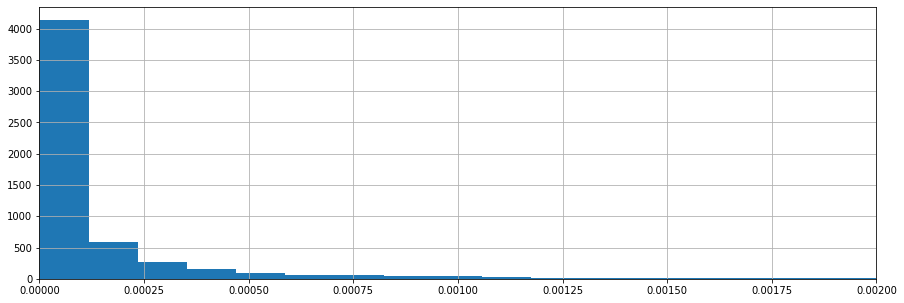

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(predictor_rf2.feature_importances_, bins=100)
plt.grid(True)
plt.xlim(0, 0.002)

Я считаю, что информативных признаков здесь много.

## Create feature selector:

Теперь отберём эти признаки. 1000 берется для повышения точности отобранных классификаторов.

In [ ]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=1000, max_depth=40)).fit(X_train, y_train)
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(137, 990) (60, 990)


## Train and evaluate the new classifiers:

Теперь обучим выбранные ранее 2 лучших классификатора на уменьшенных данных.

In [ ]:
predictor_svm_ = LinearSVC().fit(X_train_transformed, y_train)
y_pred_svm_ = predictor_svm_.predict(X_test_transformed)
print('SVM (with feature selection) accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm_), 2)))

SVM (with feature selection) accuracy: 0.85%


In [ ]:
predictor_mlp_ = MLPClassifier(alpha=1, max_iter=1000).fit(X_train_transformed, y_train)
y_pred_mlp_ = predictor_mlp_.predict(X_test_transformed)
print('MLP (with feature selection) accuracy: {}%'.format(round(np.mean(y_test == y_pred_mlp_), 2)))

MLP (with feature selection) accuracy: 0.82%


SVM оказался точнее.

Также я попробовала 2 новых классификатора **One-Vs-The-Rest и One-Vs-One**.

In [ ]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=-1).fit(X_train, y_train)
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print('One-VS-all accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.82%


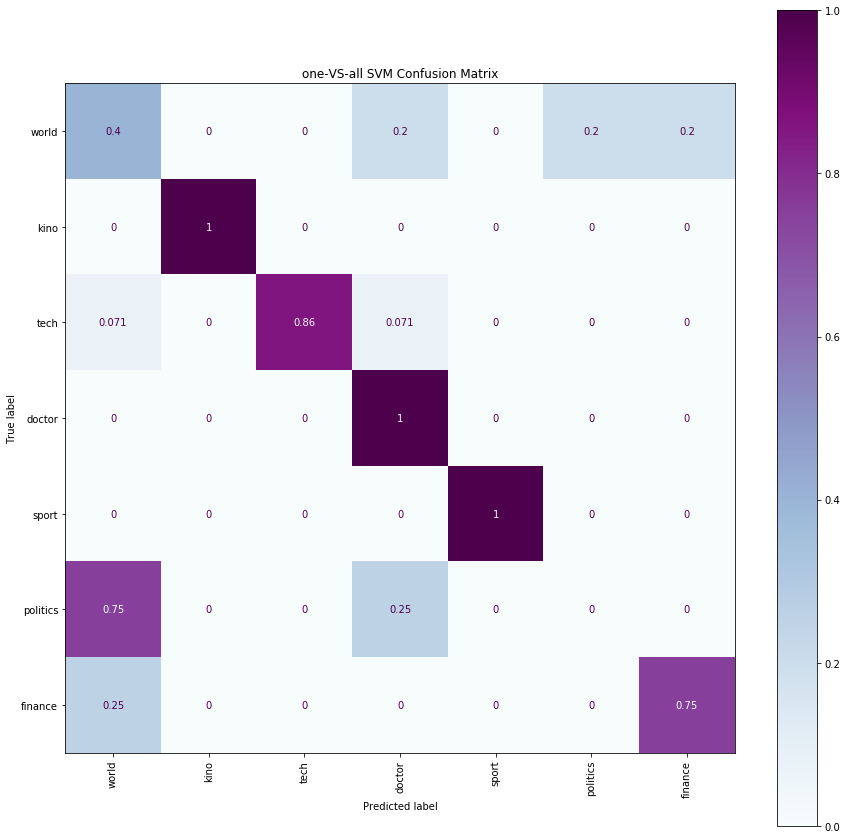

In [ ]:
Conf_Matr(predictor_oneVSall, 'one-VS-all SVM')

Этот классификатор показал довольно хорошую точность предсказания, но не обошёл SVM with feature selection.

Из визуализированной матрицы видно, что всё так же путается политика с категориями world и doctor. Категория медицина правильно определяется в лишь в 40%.

In [ ]:
predictor_oneVSone = OneVsOneClassifier(LinearSVC(), n_jobs=-1).fit(X_train, y_train)
y_pred_onevsone = predictor_oneVSone.predict(X_test)
print('One-VS-one accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsone), 2)))

One-VS-one accuracy: 0.77%


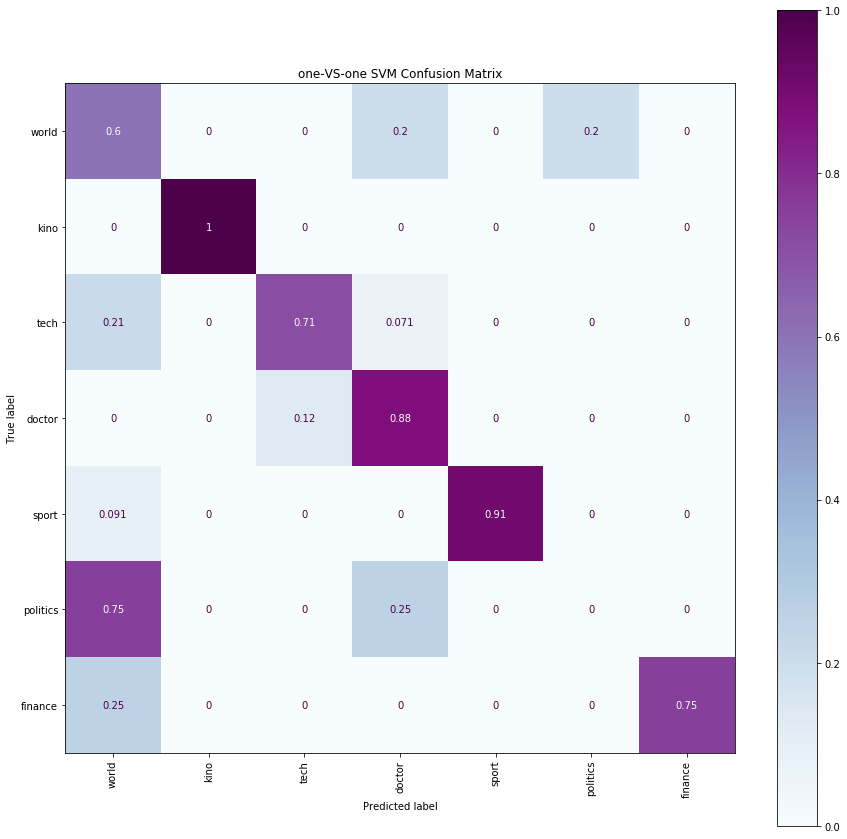

In [ ]:
Conf_Matr(predictor_oneVSone, 'one-VS-one SVM')

Точность классификатора one-vs-one уступает предыдущим моделям. В построенной матрице видны общие паттерны, как и во многих классификаторах.

## Binary Classification

Попробую построить бинарный классификатор с наиболее путавшимися между собой классами.

**Politics VS World**

In [ ]:
X_train_bin = X_train[(y_train == 0) | (y_train == 5)]
y_train_bin = y_train[(y_train == 0) | (y_train == 5)]

y_train_bin[y_train_bin == 5] = 1

X_test_bin = X_test[(y_test == 0) | (y_test == 5)]
y_test_bin = y_test[(y_test == 0) | (y_test == 5)]

y_test_bin[y_test_bin == 5] = 1

print(X_train_bin.shape, y_train_bin.shape)
print(X_test_bin.shape, y_test_bin.shape)

(42, 5680) (42,)
(9, 5680) (9,)


In [ ]:
one_binary_predictor = RandomForestClassifier(n_estimators=1000).fit(X_train_bin, y_train_bin)
y_pred_binary = one_binary_predictor.predict(X_test_bin)

**Politics VS Doctor**

In [ ]:
X_train_bin2 = X_train[(y_train == 3) | (y_train == 5)]
y_train_bin2 = y_train[(y_train == 3) | (y_train == 5)]

y_train_bin2[y_train_bin2 == 3] = 0
y_train_bin2[y_train_bin2 == 5] = 1

X_test_bin2 = X_test[(y_test == 3) | (y_test == 5)]
y_test_bin2 = y_test[(y_test == 3) | (y_test == 5)]

y_test_bin2[y_test_bin2 == 3] = 0
y_test_bin2[y_test_bin2 == 5] = 1

print(X_train_bin2.shape, y_train_bin2.shape)
print(X_test_bin2.shape, y_test_bin2.shape)

(38, 5680) (38,)
(12, 5680) (12,)


In [ ]:
one_binary_predictor2 = RandomForestClassifier(n_estimators=400).fit(X_train_bin2, y_train_bin2)
y_pred_binary2 = one_binary_predictor2.predict(X_test_bin2)

### Metrics

Посчитаем метрики для 2 бинарных классфикаторов.

In [ ]:
def FP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] != y_pred[y_true == 0]))
def TP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] == y_pred[y_true == 1]))
def FN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] != y_pred[y_true == 1]))
def TN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] == y_pred[y_true == 0]))

**Politics VS World**

In [ ]:
print('Binary classifiers accuracy: {}%'.format(round(np.mean(y_pred_binary == y_test_bin), 2)))

Binary classifiers accuracy: 0.67%


Даже с помощью бинарного классификатора не удается точно определить категорию текста: политика или мировые новости. Эти две категории оказались очень связаны между собой. И значит в этих текстах используется много одинаковых слов.

In [ ]:
fp = FP(y_test_bin, y_pred_binary)
fn = FN(y_test_bin, y_pred_binary)
tp = TP(y_test_bin, y_pred_binary)
tn = TN(y_test_bin, y_pred_binary)

print('TP = {}, FP = {}, TN = {}, FN = {}\n---------------------------------------------\nsum = {}'.format(tp, fp, tn, fn, tp + fp + tn + fn))

TP = 1.0, FP = 0.0, TN = 5.0, FN = 3.0
---------------------------------------------
sum = 9.0


In [ ]:
P = precision_score(y_test_bin, y_pred_binary)
R = recall_score(y_test_bin, y_pred_binary)
print('Precision: {}, Recall: {}'.format(P, R))

Precision: 1.0, Recall: 0.25


Классификатору можно доверять, но его полнота лишь 25%.

In [ ]:
print('F1: {}'.format(f1_score(y_test_bin, y_pred_binary)))

F1: 0.4


In [ ]:
scores_binary = one_binary_predictor.predict_proba(X_test_bin)[:, 1]
print(scores_binary.shape)

(9,)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, scores_binary)

Text(0.5, 1.0, 'ROC-кривая')

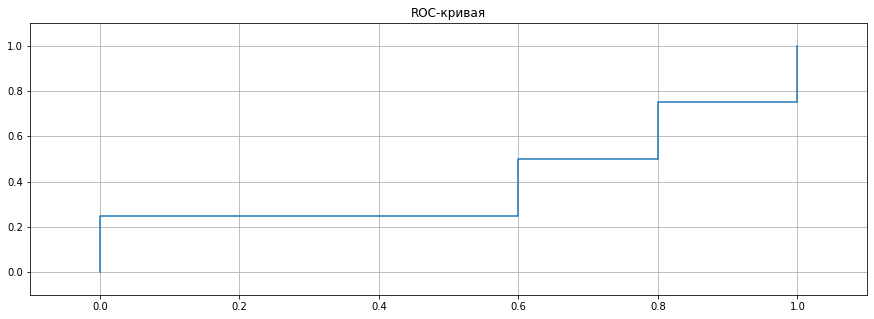

In [ ]:
plt.figure(figsize=(15, 5))
inds = np.argsort(fpr)
plt.plot(fpr[inds], tpr[inds])
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('ROC-кривая')

In [ ]:
roc_auc = roc_auc_score(y_test_bin, scores_binary)
print('AUC score: {}'.format(roc_auc, 2))

AUC score: 0.39999999999999997


Площадь под графиком маленькая, что говорит о том, что классификатор не достаточно точно предсказыавет категории.

**Politics VS Doctor**

In [ ]:
print('Binary classifiers accuracy: {}%'.format(round(np.mean(y_pred_binary2 == y_test_bin2), 2)))

Binary classifiers accuracy: 1.0%


В данном случае удается избавиться от путаницы между 2 категориями.

In [ ]:
fp2 = FP(y_test_bin2, y_pred_binary2)
fn2 = FN(y_test_bin2, y_pred_binary2)
tp2 = TP(y_test_bin2, y_pred_binary2)
tn2 = TN(y_test_bin2, y_pred_binary2)
print('TP = {}, FP = {}, TN = {}, FN = {}\n---------------------------------------------\nsum = {}'.format(tp2, fp2, tn2, fn2, tp2 + fp2 + tn2 + fn2))
print()

P2 = precision_score(y_test_bin2, y_pred_binary2)
R2 = recall_score(y_test_bin2, y_pred_binary2)
print('Precision: {}, Recall: {}'.format(P2, R2))

print('F1: {}'.format(f1_score(y_test_bin2, y_pred_binary2)))

scores_binary2 = one_binary_predictor2.predict_proba(X_test_bin2)[:, 1]
fpr2, tpr2, thresholds2 = roc_curve(y_test_bin2, scores_binary2)

TP = 4.0, FP = 1.0, TN = 7.0, FN = 0.0
---------------------------------------------
sum = 12.0

Precision: 0.8, Recall: 1.0
F1: 0.888888888888889


Судя по полноте, точности и метрике, их усредняющей, классификатор хороший.

Text(0.5, 1.0, 'ROC-кривая')

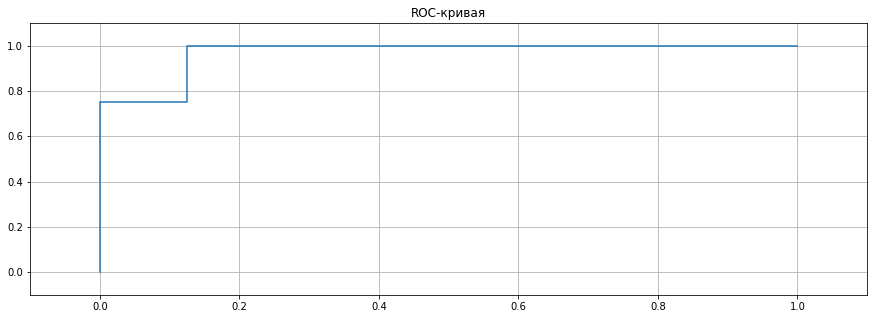

In [ ]:
plt.figure(figsize=(15, 5))
inds = np.argsort(fpr2)
plt.plot(fpr2[inds], tpr2[inds])
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('ROC-кривая')

In [ ]:
roc_auc2 = roc_auc_score(y_test_bin2, scores_binary2)
print('AUC score: {}'.format(roc_auc2, 2))

AUC score: 0.96875


Площадь под графиком большая.

## Выводы

Лучшим классификатором для собранного мною новостного корпуса оказался SVM со стандартными параметрами и точностью в 85%. Чаще всего путаются категории из мира политики и мира в целом, и это исправить не получается. Это можно понять не только из полученных результатов, а это действительно кажется разумным(если просто поразмышлять о текстах, относящихся к этим 2 категориям).